# Predicción de diabetes

Importamos librerías

In [324]:
!brew install libomp
%pip install seaborn

%pip install kagglehub
%pip install --upgrade category_encoders
%pip uninstall -y xgboost
%pip install xgboost
%pip install lightgbm
%pip install shap

==> Downloading https://formulae.brew.sh/api/formula.jws.json
==> Downloading https://formulae.brew.sh/api/cask.jws.json
To reinstall 20.1.3, run:
  brew reinstall libomp
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Found existing installation: xgboost 3.0.0
Uninstalling xgboost-3.0.0:
  Successfully uninstalled xgboost-3.0.0
Note: you may need to restart the kernel to use updated packages.
  Using cached xgboost-3.0.0-py3-none-macosx_10_15_x86_64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.0-py3-none-macosx_10_15_x86_64.whl (2.2 MB)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 15.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Pre

In [293]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [321]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from category_encoders import BinaryEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    PolynomialFeatures,
    FunctionTransformer,
)
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report

### Importamos el set de datos

Traemos el set de datos e iniciamos el análisis de estos.

In [295]:
# Data import
df = pd.read_csv('diabetes_prediction_dataset.csv')
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [296]:
# Descipción de datos
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [297]:
df.shape

(100000, 9)

In [298]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


### Análisis de datos
Revisamos la distribución de los datos, empezando por el género

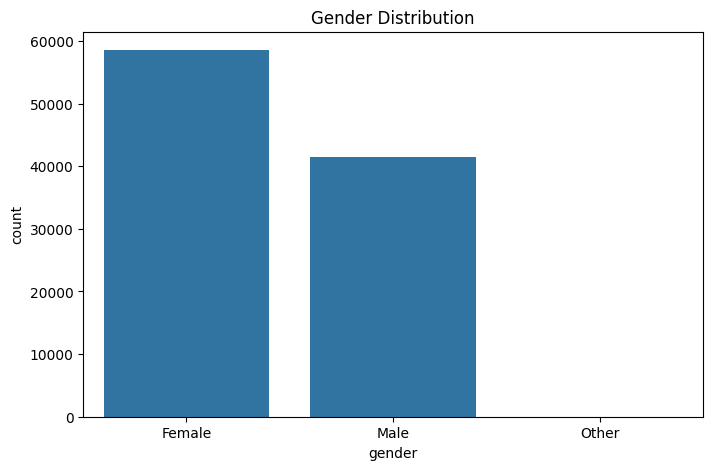

In [299]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='gender')
plt.title("Gender Distribution")
plt.show()

In [300]:
df["gender"].value_counts()

gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64

In [301]:
# Descartamos la categoría 'Other' del género
df = df[df['gender'] != 'Other']
# Revisamos de nuevo la distribución de género
df["gender"].value_counts()

gender
Female    58552
Male      41430
Name: count, dtype: int64

In [302]:
# Convertimos genero Hombre, Mujer, a 1, 0
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

In [303]:
# Validamos si tenemos valores vacíos
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

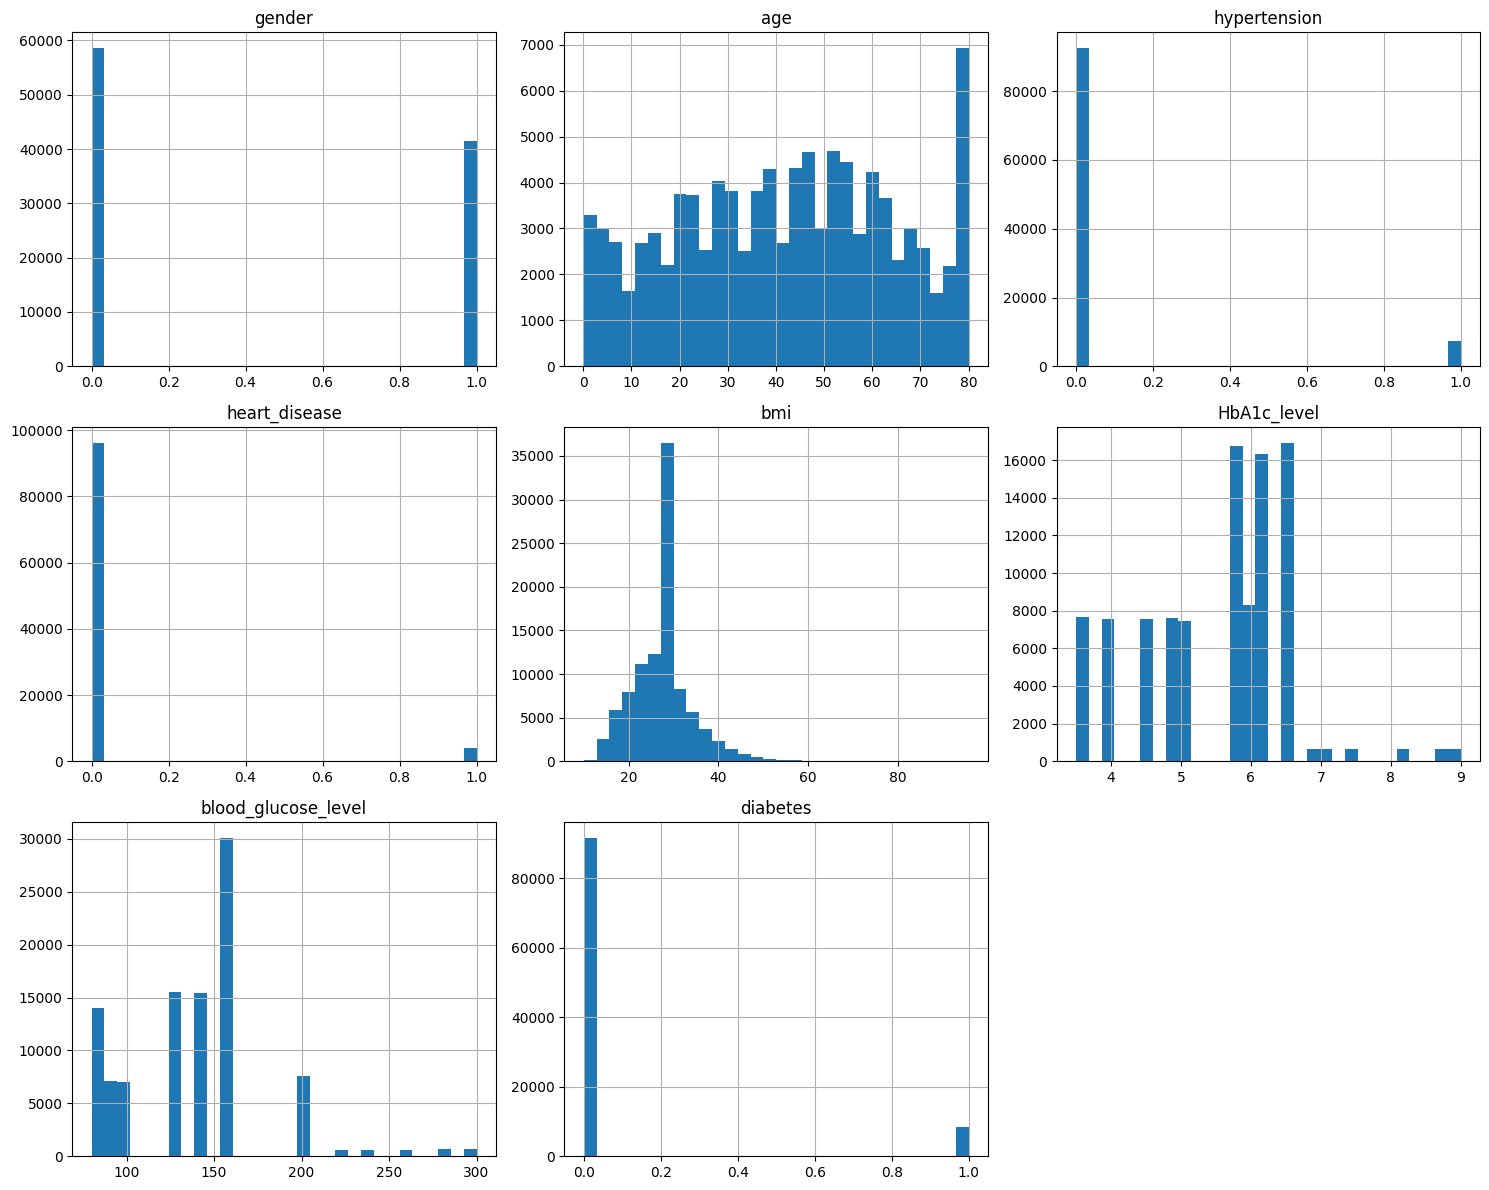

In [304]:
# Revisamos la distribución de las variables
df.hist(bins=30, figsize=(15, 12))
plt.tight_layout()
plt.show()

### Revisamos la incidencia de nuestra variable objetivo

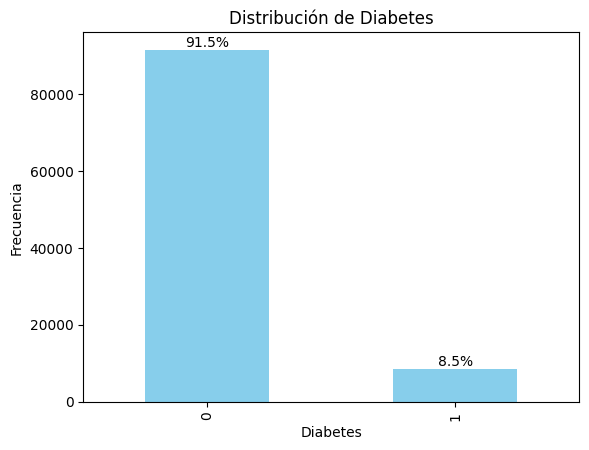

In [305]:
# Variable objetivo: Diabetes

# Calculamos la incidencia y su porcentaje respecto a la muestra
value_counts = df['diabetes'].value_counts()
percentages = (value_counts / len(df) * 100).round(2)

# Creamos un gráfico de barras para visualizar la distribución
ax = value_counts.plot(kind='bar', color='skyblue')
plt.title('Distribución de Diabetes')
plt.xlabel('Diabetes')
plt.ylabel('Frecuencia')

# Asignamos al gráfico los porcentajes
for i, count in enumerate(value_counts):
    percentage = percentages[i]
    ax.text(i, count + 1, f'{percentage}%', ha='center', va='bottom', fontsize=10)

plt.show()

In [306]:
# Revisamos los valores posibles de la variable smoking_history
unique_values = df['smoking_history'].unique()

In [307]:
# Convertimos el historial de fumador a 1, 0
# En la muestra, todos los que en algún momento han fumado son considerados fumadores
# y los que nunca han fumado son considerados no fumadores
df['smoking_history'] = df['smoking_history'].map({
    'No Info': 0,
    'never': 0,
    'former': 1,
    'current': 1,
    'not current': 1,
    'ever': 1
})

Generating Count Plots...


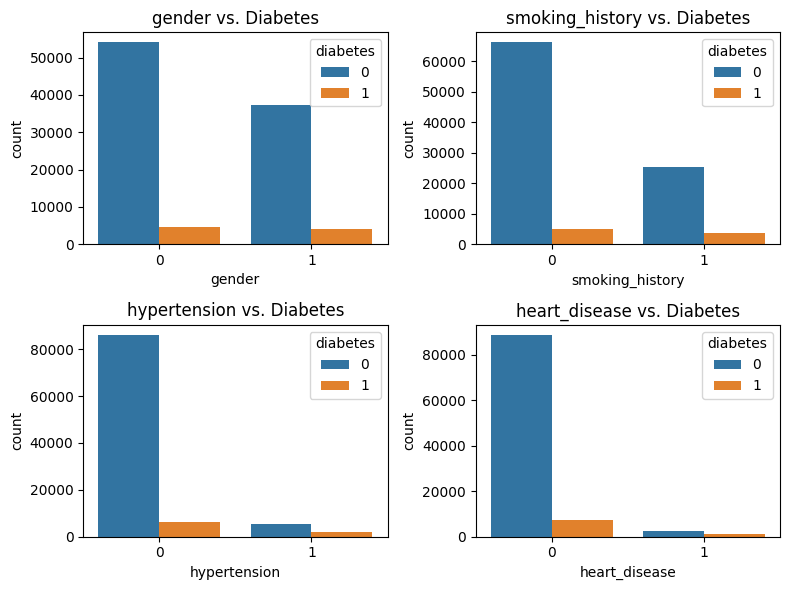

In [308]:
print("Generating Count Plots...")
categorical_cols = ['gender', 'smoking_history', 'hypertension', 'heart_disease']

# First figure with first 4 plots
fig1, axes1 = plt.subplots(2, 2, figsize=(8, 6))
axes1 = axes1.flatten()  # Flatten for easier indexing

for i in range(min(4, len(categorical_cols))):
    sns.countplot(x=categorical_cols[i], hue='diabetes', data=df, ax=axes1[i])
    axes1[i].set_title(f'{categorical_cols[i]} vs. Diabetes')

plt.tight_layout()
plt.show()

# Second figure with remaining plots
if len(categorical_cols) > 4:
    fig2, axes2 = plt.subplots(1, len(categorical_cols)-4, figsize=(8, 6))
    if len(categorical_cols) == 5:  # Handle case of just one subplot
        axes2 = [axes2]
        
    for i in range(4, len(categorical_cols)):
        sns.countplot(x=categorical_cols[i], hue='diabetes', data=df, ax=axes2[i-4])
        axes2[i-4].set_title(f'{categorical_cols[i]} vs. Diabetes')
    
    plt.tight_layout()
    plt.show()

In [309]:
# Show duplicates
df.duplicated().sum()
# Drop duplicates
df = df.drop_duplicates()
# Check again
df.duplicated().sum()

np.int64(0)

In [310]:
# Check the shape of the DataFrame
df.shape

(93718, 9)

In [311]:
df.sample(10)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
87944,1,7.0,0,0,0,18.11,6.0,158,0
66763,1,79.0,0,0,1,27.32,7.5,126,1
62141,1,50.0,0,0,0,28.43,6.0,85,0
91411,0,62.0,1,0,0,36.35,4.5,80,0
18138,0,58.0,0,0,1,24.14,5.8,159,0
2207,0,22.0,0,0,0,27.32,6.2,158,0
25057,0,62.0,0,0,0,25.11,4.0,85,0
33683,1,3.0,0,0,0,15.41,6.1,90,0
71570,0,30.0,0,0,0,30.34,4.5,100,0
33241,0,71.0,0,0,0,30.55,4.8,90,0


In [312]:
numeric_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
binary_features = ['smoking_history', 'hypertension', 'heart_disease', 'gender']

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('binary', 'passthrough', binary_features)
    ]
)

# Create the full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Split the data
X = df.drop('diabetes', axis=1)
y = df['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and transform the data
pipeline.fit(X_train, y_train)

# Get feature names after transformation
feature_names = numeric_features + binary_features

print("Feature names after transformation:")
print(feature_names) 

Feature names after transformation:
['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'smoking_history', 'hypertension', 'heart_disease', 'gender']



Métricas del modelo de Regresión Logística:
MAE (Error Absoluto Medio): 0.0424
R² (Coeficiente de Determinación): 0.4850

Matriz de Confusión:


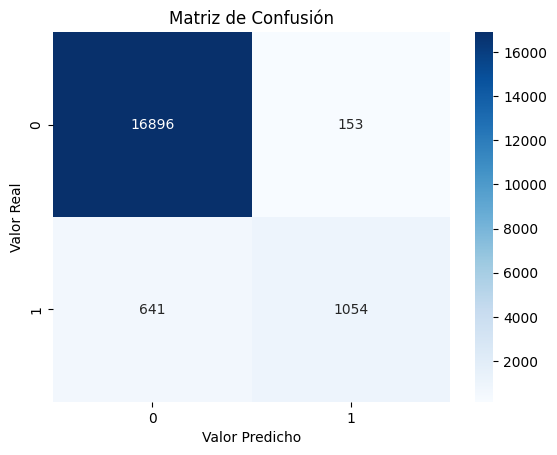


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     17049
           1       0.87      0.62      0.73      1695

    accuracy                           0.96     18744
   macro avg       0.92      0.81      0.85     18744
weighted avg       0.96      0.96      0.95     18744



In [313]:
# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate metrics

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nMétricas del modelo de Regresión Logística:")
print(f"MAE (Error Absoluto Medio): {mae:.4f}")
print(f"R² (Coeficiente de Determinación): {r2:.4f}")

# También podemos ver la matriz de confusión para entender mejor el rendimiento

print("\nMatriz de Confusión:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

### Random forest

In [317]:
# Creamos un nuevo pipeline para el modelo de Random Forest
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Definamos la malla de parámetros sobre la que haremos la búsqueda:
param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': list(range(6, 10)),
    'regressor__min_samples_leaf': [10, 300, 2000]
}
# Definamos nuestros modelo mediante GridSearchCV:
rf = GridSearchCV(pipeline_rf, cv=3, param_grid=param_grid)
# Fit the Random Forest model
rf.fit(X_train, y_train)
print(rf.best_params_)

{'regressor__max_depth': 9, 'regressor__min_samples_leaf': 10, 'regressor__n_estimators': 100}


Train set
Model: Random Forest
R^2: 0.7086483313886562
MAE: 0.048591903471636964


Test set
Model: Random Forest
R^2: 0.7033522074779047
MAE: 0.04939906003839173



Matriz de Confusión:


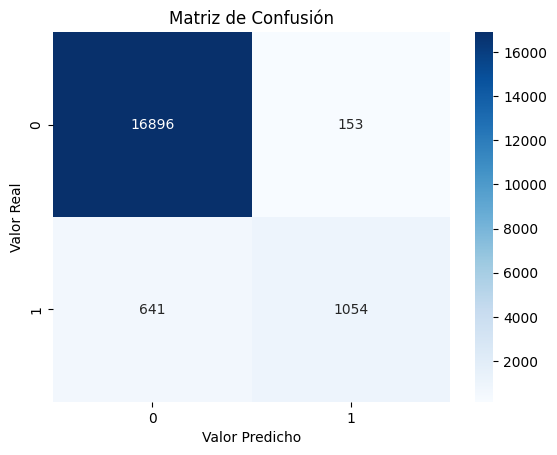


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     17049
           1       0.87      0.62      0.73      1695

    accuracy                           0.96     18744
   macro avg       0.92      0.81      0.85     18744
weighted avg       0.96      0.96      0.95     18744



In [319]:
# Obtengamos el R^2 y el MAE de entrenamiento para cada modelo:
print("Train set")
print(f"Model: {'Random Forest'}")
print(f'R^2: {rf.score(X_train, y_train)}')
print(f'MAE: {mean_absolute_error(y_train, rf.predict(X_train))}')
print('\n')

print("Test set")
print(f"Model: {'Random Forest'}")
print(f'R^2: {rf.score(X_test, y_test)}')
print(f'MAE: {mean_absolute_error(y_test, rf.predict(X_test))}')
print('\n')

# También podemos ver la matriz de confusión para entender mejor el rendimiento
# Make predictions
y_pred_rf = pipeline.predict(X_test)

print("\nMatriz de Confusión:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

### Gradient boosting

In [322]:
# Creamos un nuevo pipeline para el modelo de Gradient Boosting
pipeline_gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

# Definamos la malla de parámetros sobre la que haremos la búsqueda:
param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': list(range(6, 10)),
    'regressor__min_samples_leaf': [10, 300, 2000]
}
# Definamos nuestros modelo mediante GridSearchCV:
gb = GridSearchCV(pipeline_gb, cv=3, param_grid=param_grid)
# Fit the Gradient Boosting model
gb.fit(X_train, y_train)
print(gb.best_params_)

{'regressor__max_depth': 7, 'regressor__min_samples_leaf': 10, 'regressor__n_estimators': 50}


Train set
Model: Gradient Boosting
R^2: 0.7167695228346602
MAE: 0.0491908975943316


Test set
Model: Gradient Boosting
R^2: 0.7085682724693777
MAE: 0.050168676744102435



Matriz de Confusión:


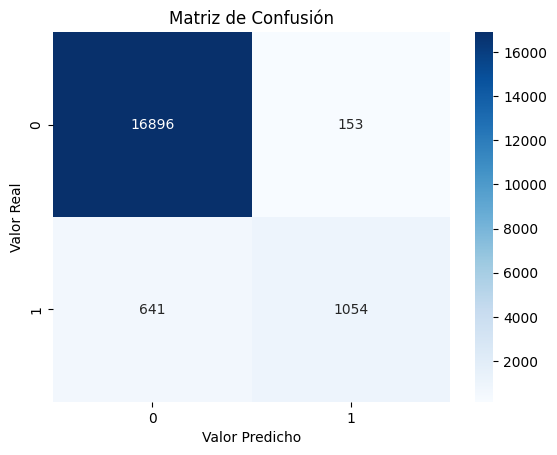


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     17049
           1       0.87      0.62      0.73      1695

    accuracy                           0.96     18744
   macro avg       0.92      0.81      0.85     18744
weighted avg       0.96      0.96      0.95     18744



In [326]:
# Obtengamos el R^2 y el MAE de entrenamiento para cada modelo:
print("Train set")
print(f"Model: {'Gradient Boosting'}")
print(f'R^2: {gb.score(X_train, y_train)}')
print(f'MAE: {mean_absolute_error(y_train, gb.predict(X_train))}')
print('\n')

print("Test set")
print(f"Model: {'Gradient Boosting'}")
print(f'R^2: {gb.score(X_test, y_test)}')
print(f'MAE: {mean_absolute_error(y_test, gb.predict(X_test))}')
print('\n')

# También podemos ver la matriz de confusión para entender mejor el rendimiento
# Make predictions
y_pred_gb = pipeline.predict(X_test)

print("\nMatriz de Confusión:")
cm_gb = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

### Explicabilidad
Usaremos Shap

In [325]:
import shap
from IPython.display import HTML

/Users/jarestrepogu/.pyenv/versions/3.13.3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [327]:
#Entrenamos nuestro pipeline con los mejores parámetros encontrados en la validación cruzada
pipeline_gb.set_params(**gb.best_params_)
pipeline_gb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'HbA1c_level',
                                                   'blood_glucose_level']),
                                                 ('binary', 'passthrough',
                                                  ['smoking_history',
                                                   'hypertension',
                                                   'heart_disease',
                                                   'gender'])])),
                ('regressor',
                 GradientBoostingRegressor(max_depth=7, min_samples_leaf=10,
                                           n_estimators=50, random_state=42))])

In [328]:
y_est = pipeline_gb.predict(X_train)
Efx = np.mean(y_est)

In [329]:
Efx

np.float64(0.09024461813428654)

In [330]:
gb_explainer = shap.TreeExplainer(pipeline_gb.named_steps["regressor"])
train_gb_shap_values = gb_explainer.shap_values(X_train)

In [331]:
val = train_gb_shap_values.sum(axis=1)

In [332]:
val

array([0.25415435, 0.31492095, 0.31492095, ..., 0.46943595, 0.31492095,
       0.31492095], shape=(74974,))

In [333]:
fx = Efx + val

In [334]:
fx

array([0.34439896, 0.40516557, 0.40516557, ..., 0.55968057, 0.40516557,
       0.40516557], shape=(74974,))

In [335]:
y_est

array([ 0.02045677,  0.11208951, -0.00017595, ...,  0.00091831,
       -0.00330714,  0.04803653], shape=(74974,))

In [336]:
train_gb_shap_values[1].shape

(8,)

In [337]:
test_gb_shap_values = gb_explainer.shap_values(X_test)
test_gb_shap_values[1].shape

(8,)

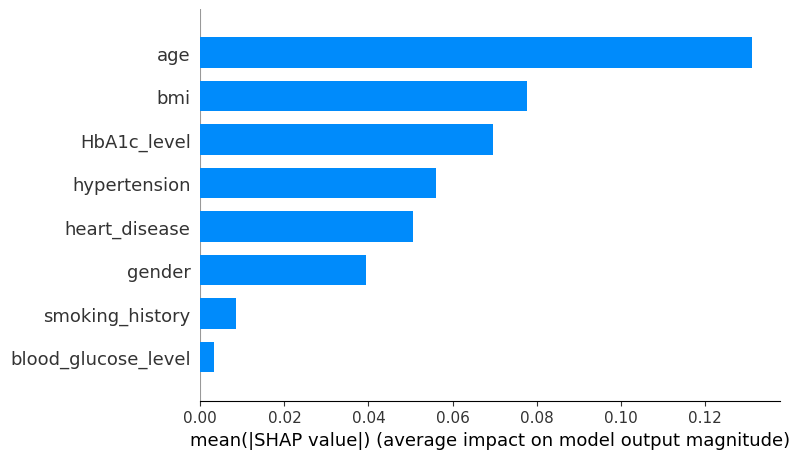

In [338]:
# Summary plot
shap.summary_plot(test_gb_shap_values, X_test, plot_type="bar")

In [339]:
shap.initjs()

# Individual SHAP value plot for a specific instance (e.g., the first instance in the test set)
instance_index = 0
force_plot_html = shap.force_plot(gb_explainer.expected_value, test_gb_shap_values[instance_index], X_test.iloc[instance_index],show=False)
HTML(force_plot_html.html())

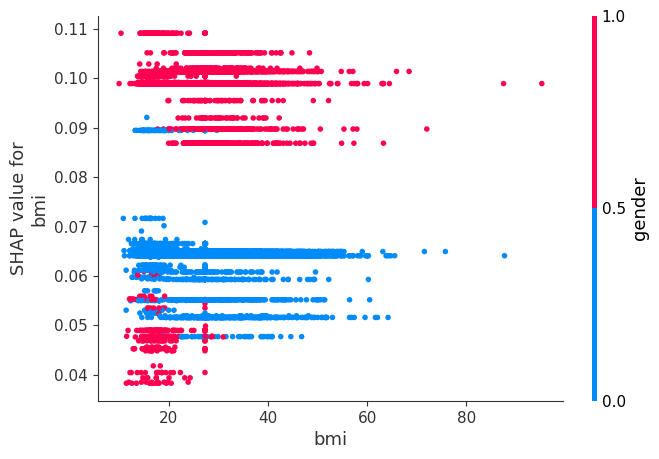

In [341]:
#Dependence plot
shap.dependence_plot('bmi', test_gb_shap_values, X_test)

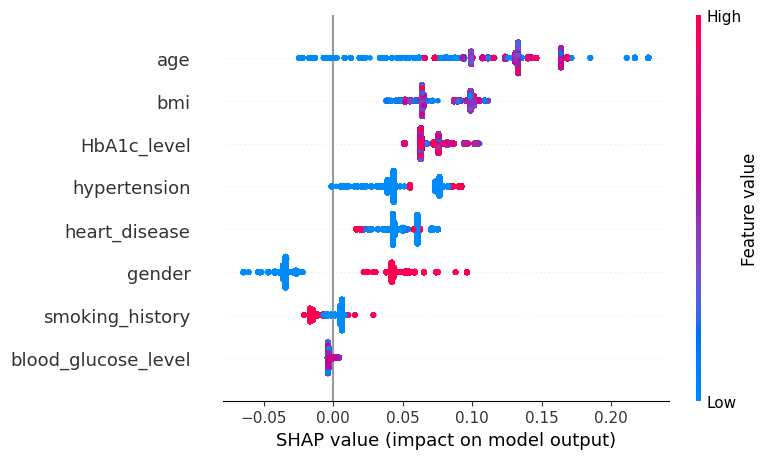

In [342]:
#Summary plot
shap.summary_plot(train_gb_shap_values, X_train)